In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [47]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [14]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
print(f"the tmin, tavg, and tmax for a year in the data set is "\
      f"{calc_temps('2016-08-24','2017-08-23')}")

the tmin, tavg, and tmax for a year in the data set is [(58.0, 74.57894736842105, 87.0)]


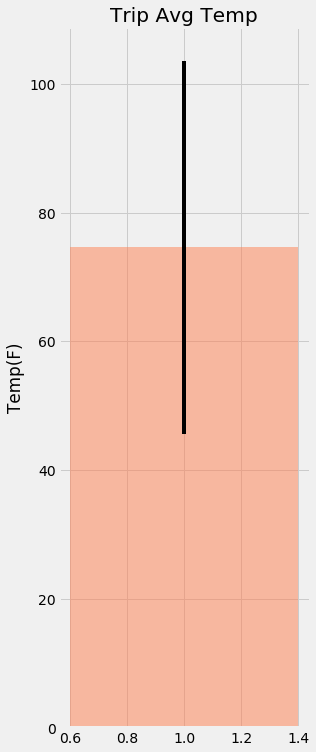

In [46]:
# Plot the results from your previous query as a bar chart. 
fig, ax = plt.subplots(figsize=plt.figaspect(3.))
tmin,tavg,tmax = calc_temps('2016-08-24','2017-08-23')[0]

# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax-tmin
plt.bar(1, height = tavg, yerr =yerr,alpha=0.5, color='coral', align="center" )
plt.savefig("images/avg.png")
plt.show()

### Daily Rainfall Average

In [65]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station,Station.name,Station.latitude,Station.longitude, Station.elevation).\
             filter(Measurement.station == Station.station).\
             filter(Measurement.date>='2016-08-24').\
             filter(Measurement.date<='2017-08-23').\
             group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

### Daily Temperature Normals

In [66]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [95]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start=start_date,end=end_date)

# Strip off the year and save a list of strings in the format %m-%d
trip_dates_normal = dates.strftime('%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
for normal in trip_dates_normal:
    normals.append(daily_normals(normal))
# and append the results to a list called `normals`.

In [116]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin = []
tmax = []
tavg = []
for normal in normals:
    for i in normal:
        tmin.append(i[0])
        tavg.append(i[1])
        tmax.append(i[2])
        
normal_df = pd.DataFrame({"tmin" : tmin, "tavg" : tavg, "tmax" : tmax}).set_index(trip_dates_normal)
normal_df.index.name = "date"
normal_df

,tmin,tavg,tmax
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


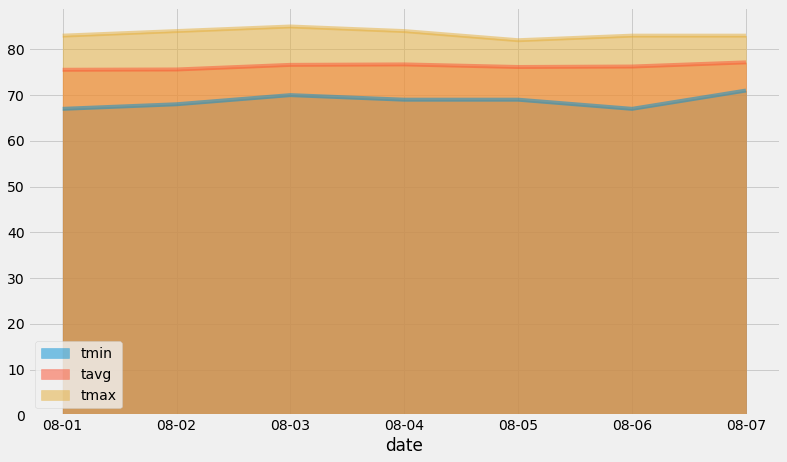

In [123]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normal_df.plot.area(stacked=False,figsize=(12,7))
ax.set_ylabel("Temp()")
plt.show()

## Close Session

In [ ]:
session.close()